In [1]:
# Setting up environment

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import joblib

from sklearn.preprocessing import StandardScaler
import category_encoders as ce

from dotenv import load_dotenv

load_dotenv()
mpl.rcParams['figure.figsize'] = (12, 10)

In [2]:
# drop colomn
def dropColomn(df, col):
    try:
        df = df.drop(col,1)
    except:
        print('colomn {0} not found'.format(col))
    return df

# split dataframe to feature target numpy array
def split_feature_label(df):
    return df.iloc[:, :-1].values, df.iloc[:, -1].values

In [3]:
# processing testing dataset

# import dataset
test_df = pd.read_csv(os.getcwd()+'/datasets/testing.csv')
# drop colomn id
test_df = dropColomn(test_df, 'id')

# split features and labels
x_test, y_test = split_feature_label(test_df)

print('shape of testing feature: {0}'.format(x_test.shape))
print('shape of testing labels: {0}'.format(y_test.shape))

shape of testing feature: (542, 14)
shape of testing labels: (542,)


In [4]:
# processing training dataset
# import dataset
dataset = pd.read_csv(os.getcwd()+'/datasets/sampled_dataset.csv')

# drop colomm id
dataset = dropColomn(dataset, 'id')

# split features and labels
x,y = split_feature_label(dataset)

print('shape of training feature: {0}'.format(x.shape))
print('shape of training labels: {0}'.format(y.shape))


shape of training feature: (3676, 14)
shape of training labels: (3676,)


In [5]:
# hot encoding training and testing labels

def hotEncodingLabels(arr, col):

    data = pd.DataFrame(map(str, arr), columns = [col])

    # creating instance of one-hot-encoder
    encoder = ce.OneHotEncoder(cols=col,handle_unknown='ignore', return_df=True, use_cat_names=True)

    data_encoded = encoder.fit_transform(data)

    return data_encoded

ymc = hotEncodingLabels(y,'label')
ymc_test = hotEncodingLabels(y_test,'label')

In [6]:
# split to training and validating dataset
from sklearn.model_selection import train_test_split

TESTSIZE = float(os.getenv('VALRATE'))
TESTRANDOMSTATE = int(os.getenv('VALRANDOMSTATE'))

x_train, x_val, y_train, y_val = train_test_split(x, ymc, test_size = TESTSIZE, random_state = TESTRANDOMSTATE)

print('shape of training feature: {0}'.format(x_train.shape))
print('shape of training labels: {0}'.format(y_train.shape))

print('shape of validation feature: {0}'.format(x_val.shape))
print('shape of validation labels: {0}'.format(y_val.shape))


shape of training feature: (2757, 14)
shape of training labels: (2757, 2)
shape of validation feature: (919, 14)
shape of validation labels: (919, 2)


In [7]:
# Scaling data using standar scaler
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_val = sc.transform(x_val)
x_test = sc.transform(x_test)

# save scaler variable into file
scaler_filename = os.getenv("SCALER_FILENAME")
joblib.dump(sc, scaler_filename) 


['model/scaler.save']

In [8]:
# building model

BATCH_SIZE = int(os.getenv('BATCHSIZE'))
EPOCHS = int(os.getenv('EPOCH'))

METRICS = [
    # keras.metrics.TruePositives(name='tp'),
    # keras.metrics.FalsePositives(name='fp'),
    # keras.metrics.TrueNegatives(name='tn'),
    # keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    # keras.metrics.AUC(name='auc'),
    # keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS ):
    model = keras.Sequential([
        keras.layers.Dense(
            14, activation='relu',
            input_shape=(x_train.shape[-1],)),
        # keras.layers.Dropout(0.3),
        keras.layers.Dense(
            14, activation='relu'),
        keras.layers.Dense(2, activation='softmax'),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=metrics)

    return model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=32,
    mode='max',
    restore_best_weights=True)

In [9]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 30        
Total params: 450
Trainable params: 450
Non-trainable params: 0
_________________________________________________________________


In [10]:
zero_bias_history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=early_stopping)

Epoch 1/1024
44/44 [==============================] - 1s 8ms/step - loss: 0.6852 - accuracy: 0.5771 - precision: 0.5771 - recall: 0.5771 - val_loss: 0.6625 - val_accuracy: 0.6148 - val_precision: 0.6148 - val_recall: 0.6148
Epoch 2/1024
44/44 [==============================] - 0s 2ms/step - loss: 0.6467 - accuracy: 0.6170 - precision: 0.6170 - recall: 0.6170 - val_loss: 0.6398 - val_accuracy: 0.6398 - val_precision: 0.6398 - val_recall: 0.6398
Epoch 3/1024
44/44 [==============================] - 0s 2ms/step - loss: 0.6274 - accuracy: 0.6503 - precision: 0.6503 - recall: 0.6503 - val_loss: 0.6270 - val_accuracy: 0.6594 - val_precision: 0.6594 - val_recall: 0.6594
Epoch 4/1024
44/44 [==============================] - 0s 2ms/step - loss: 0.6166 - accuracy: 0.6547 - precision: 0.6547 - recall: 0.6547 - val_loss: 0.6178 - val_accuracy: 0.6692 - val_precision: 0.6692 - val_recall: 0.6692
Epoch 5/1024
44/44 [==============================] - 0s 2ms/step - loss: 0.6099 - accuracy: 0.6678 - pr

In [11]:
model.save('model/ann_model')

INFO:tensorflow:Assets written to: model/ann_model/assets


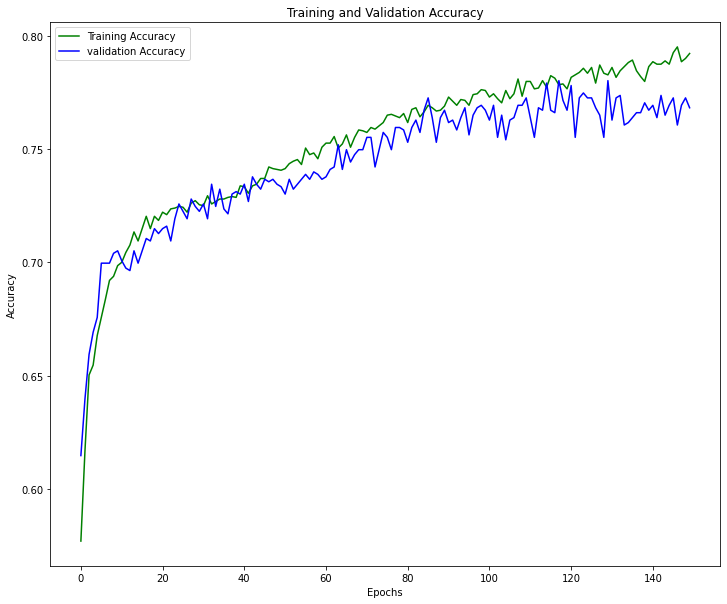

In [12]:
loss_train = zero_bias_history.history['accuracy']
loss_val = zero_bias_history.history['val_accuracy']
epochs = range(len(zero_bias_history.history['accuracy']))
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

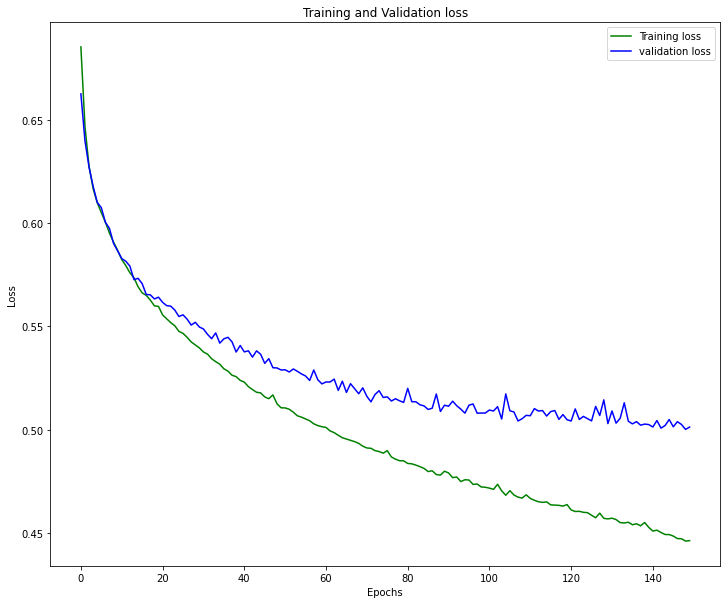

In [13]:
loss_train = zero_bias_history.history['loss']
loss_val = zero_bias_history.history['val_loss']
epochs = range(len(zero_bias_history.history['loss']))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions >= p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): {0}, with percentage : {1}'.format(cm[0][0], cm[0][0]/len(labels)))
    print('Legitimate Transactions Incorrectly Detected (False Positives): {0}, with percentage : {1}'.format(cm[0][1], cm[0][1]/len(labels)))
    print('Fraudulent Transactions Missed (False Negatives): {0}, with percentage : {1}'.format(cm[1][0], cm[1][0]/len(labels)))
    print('Fraudulent Transactions Detected (True Positives): {0}, with percentage : {1}'.format(cm[1][1], cm[1][1]/len(labels)))
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

    print('Accuracy : ', accuracy_score(labels, predictions > p))

In [ ]:
def MultiResultToBinary(result):
    if type(result) == 'pandas.core.frame.DataFrame'{
        result = result.to_numpy()
    }

    print(type(result))

In [17]:
y_pred = model.predict(x_test)

print(type(y_pred))

print(type(ymc))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [16]:
# predicting test data
y_pred = model.predict(x_test)
y_pred_binary = []

for pred in y_pred:
    if pred[0] > pred[1]:
        y_pred_binary.append([1,0])
    else:
        y_pred_binary.append([0,1])
y_pred_binary = np.array(y_pred_binary)

# print(ymc_test.shape)
# print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
# plot_cm(y_test, y_pred)
cm = confusion_matrix(ymc_test, y_pred_binary)

ValueError: multilabel-indicator is not supported

In [ ]:
# conf matrix on validation data

y_pred = model.predict(x_val)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_val.reshape(len(y_val),1)),1))

plot_cm(y_val, y_pred)